In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
politifact_real = pd.read_csv('politifact_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
gossipcop_fake = pd.read_csv('gossipcop_fake.csv')

In [ ]:
politifact_real['label'] = 1
politifact_fake['label'] = 0
gossipcop_real['label'] = 1
gossipcop_fake['label'] = 0

In [ ]:
df = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

In [ ]:
df = df.dropna(subset=['title'])

In [ ]:
def advanced_preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower() 
    doc = nlp(text) 
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token) > 2]  # Lemmatize
    return " ".join(tokens)

df['processed_title'] = df['title'].apply(advanced_preprocess_text)

In [ ]:
def extract_entities(text):
    doc = nlp(text)
    entity_counts = {"ORG": 0, "GPE": 0, "PERSON": 0} 
    for ent in doc.ents:
        if ent.label_ in entity_counts:
            entity_counts[ent.label_] += 1
    return entity_counts

df['entity_counts'] = df['processed_title'].apply(extract_entities)

In [ ]:
entity_df = pd.json_normalize(df['entity_counts'])
df = pd.concat([df, entity_df], axis=1)

In [ ]:
df['article_length'] = df['title'].apply(lambda x: len(x.split())) 
df['sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)  
df['avg_word_length'] = df['title'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df['num_punctuations'] = df['title'].apply(lambda x: len(re.findall(r'[.!?]', x)))
df['num_uppercase'] = df['title'].apply(lambda x: len(re.findall(r'[A-Z]', x)))

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_features = tfidf_vectorizer.fit_transform(df['processed_title']).toarray()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_features, columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])])
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [ ]:
features = ['ORG', 'GPE', 'PERSON', 'article_length', 'sentiment', 'avg_word_length', 'num_punctuations', 'num_uppercase'] + list(tfidf_df.columns)

In [ ]:
X = df[features]
y = df['label'] 

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
rf_best_model = grid_search.best_estimator_

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf_best_model), ('xgb', xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

In [ ]:
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
entity_totals = df[['ORG', 'GPE', 'PERSON']].sum()
entity_totals.plot(kind='bar', title='Entity Frequencies')
plt.ylabel('Frequency')
plt.show()

In [ ]:
correlation_matrix = df[features + ['label']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.4s
[CV] END max_depth=10, min_s

[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total tim

[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  14.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  13.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  13.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  20.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  20.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  20.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total tim

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  19.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  39.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  35.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  35.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  55.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  56.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  51.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estim

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  37.5s


C:\Users\kamya.000\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [17:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kamya.000\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [17:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Accuracy: 0.8745879317758349
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3494
           1       0.85      0.91      0.88      3483

    accuracy                           0.87      6977
   macro avg       0.88      0.87      0.87      6977
weighted avg       0.88      0.87      0.87      6977



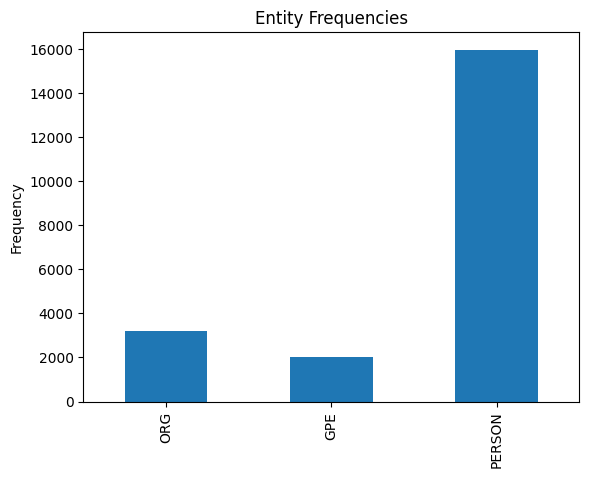

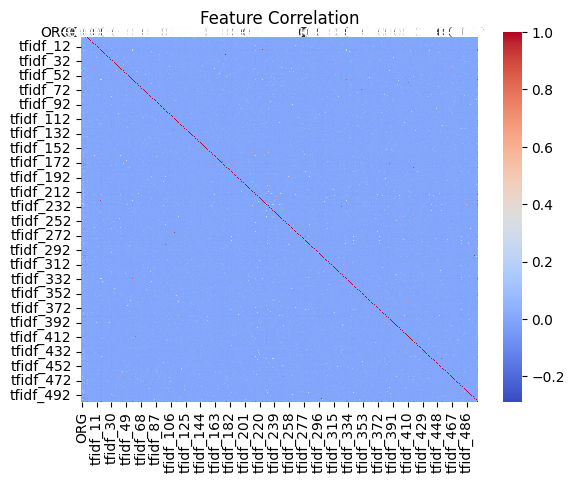

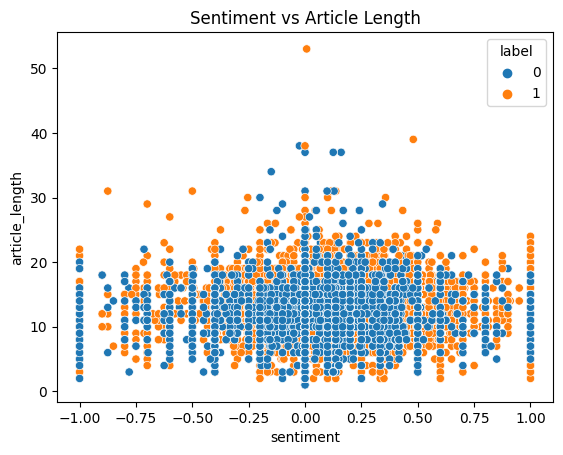

In [92]:
sns.scatterplot(x='sentiment', y='article_length', hue='label', data=df)
plt.title("Sentiment vs Article Length")
plt.show()